In [ ]:
!pip install midiutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54569 sha256=a4f1ffae78d4f7705850c4693323388d4a618aa6941602e8960b9087bdfbc4c8
  Stored in directory: /root/.cache/pip/wheels/6c/42/75/fce10c67f06fe627fad8acd1fd3a004a24e07b0f077761fbbd
Successfully built midiutil


Epoch 0 | Loss: 11.0880
Epoch 50 | Loss: 0.0189
Epoch 100 | Loss: 0.0058
Epoch 150 | Loss: 0.0029
Epoch 200 | Loss: 0.0018
Epoch 250 | Loss: 0.0012
Epoch 299 | Loss: 0.0009

🎉 Found 50 valid generated Magic Squares out of 50 attempts!

🎯 Final Accuracy: 100.00% (40/40)

🧮 Magic Square #1:
[2, 9, 4]
[7, 5, 3]
[6, 1, 8]


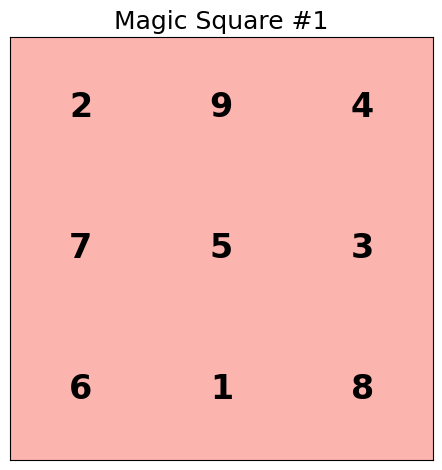

🖼️ Saved plot to magic_square_1.png
🎵 Saved MIDI with tempo 180 BPM as magic_square_1.mid

🧮 Magic Square #2:
[6, 1, 8]
[7, 5, 3]
[2, 9, 4]


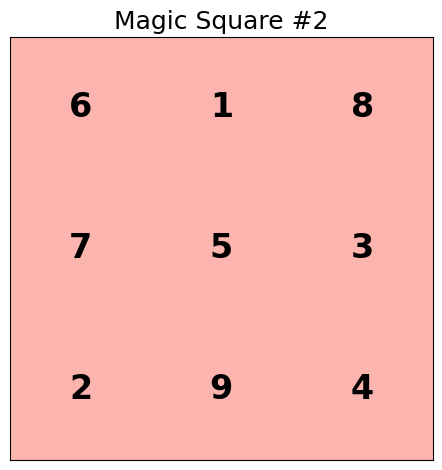

🖼️ Saved plot to magic_square_2.png
🎵 Saved MIDI with tempo 180 BPM as magic_square_2.mid

🧮 Magic Square #3:
[8, 3, 4]
[1, 5, 9]
[6, 7, 2]


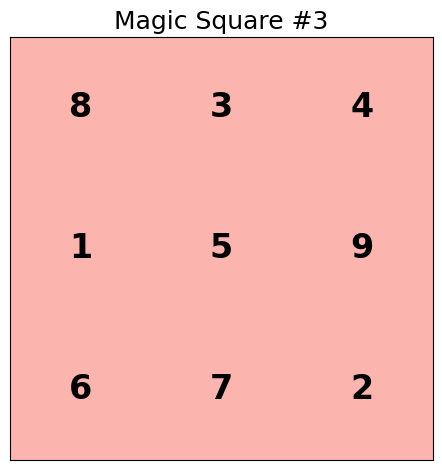

🖼️ Saved plot to magic_square_3.png
🎵 Saved MIDI with tempo 180 BPM as magic_square_3.mid


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from midiutil import MIDIFile
import numpy as np
import matplotlib.pyplot as plt
import random

# ====== 1. Define the known Magic Squares dataset ======
# Each list contains 9 numbers forming a 3x3 magic square (sum of rows, cols, diags = 15)
magic_squares = [
    [8,1,6,3,5,7,4,9,2],
    [6,1,8,7,5,3,2,9,4],
    [4,9,2,3,5,7,8,1,6],
    [2,9,4,7,5,3,6,1,8],
    [8,3,4,1,5,9,6,7,2],
    [4,3,8,9,5,1,2,7,6],
    [6,7,2,1,5,9,8,3,4],
    [2,7,6,9,5,1,4,3,8]
]

# ====== 2. Prepare training sequences from magic squares ======
seq_len = 4  # Length of input sequence to predict the next number
inputs, targets = [], []

# For each magic square, create sequences of length seq_len to predict the next number
for square in magic_squares:
    for i in range(len(square) - seq_len):
        inputs.append(square[i:i+seq_len])      # Input sequence (4 numbers)
        targets.append(square[i+seq_len])       # Target is the next number after input seq

# Convert inputs and targets to tensors
# Subtract 1 because embedding layers expect indices starting from 0
inputs = torch.tensor(inputs, dtype=torch.long) - 1
targets = torch.tensor(targets, dtype=torch.long) - 1

# Create a dataset and data loader for batch training
ds = TensorDataset(inputs, targets)
loader = DataLoader(ds, batch_size=8, shuffle=True)

# ====== 3. Define the neural network model ======
class MagicMelodyNet(nn.Module):
    def __init__(self, vocab_size=9, embed_size=16, hidden_size=64):
        super().__init__()
        # Embedding layer to convert discrete numbers (1-9) into dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # LSTM layer to capture sequence dependencies
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        # Fully connected output layer to predict next number probabilities
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)       # Shape: (batch_size, seq_len, embed_size)
        out, _ = self.lstm(x)       # LSTM outputs all hidden states
        return self.fc(out[:, -1, :])  # Use last hidden state to predict next number

# Instantiate model, loss function, and optimizer
model = MagicMelodyNet()
criterion = nn.CrossEntropyLoss()   # Suitable for classification tasks
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)

# ====== 4. Training loop ======
for epoch in range(300):
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        out = model(xb)                # Forward pass
        loss = criterion(out, yb)      # Compute loss
        loss.backward()                # Backpropagation
        optimizer.step()               # Update weights
        total_loss += loss.item()
    # Print progress every 50 epochs and at last epoch
    if epoch % 50 == 0 or epoch == 299:
        print(f"Epoch {epoch} | Loss: {total_loss:.4f}")

# ====== 5. Helper function to validate if a sequence forms a magic square ======
def is_magic_square(square):
    # Check length and uniqueness of numbers (should be 1 to 9)
    if len(square) != 9 or set(square) != set(range(1, 10)):
        return False
    grid = np.array(square).reshape((3, 3))
    rows = grid.sum(axis=1)
    cols = grid.sum(axis=0)
    diag1 = grid.trace()
    diag2 = np.fliplr(grid).trace()
    # Valid magic square: all sums must be 15
    return (
        all(val == 15 for val in rows) and
        all(val == 15 for val in cols) and
        diag1 == 15 and diag2 == 15
    )

# ====== 6. Function to generate a candidate magic square sequence ======
def generate_candidate(model, seed, steps=5):
    seq = seed.copy()  # Start sequence with the given seed
    for _ in range(steps):
        # Take last seq_len numbers, adjust for embedding indices
        x = torch.tensor(seq[-seq_len:], dtype=torch.long).unsqueeze(0) - 1
        with torch.no_grad():
            pred = model(x)                   # Predict next note logits
            next_note = torch.argmax(pred, dim=1).item() + 1  # Convert back to 1-based number
        seq.append(next_note)                 # Append predicted note
    return seq

# ====== 7. Generate multiple valid magic squares by sampling ======
valid_magic_squares = []
num_attempts = 50
for _ in range(num_attempts):
    seed = random.choice(magic_squares)[:seq_len]          # Random seed from dataset
    candidate = generate_candidate(model, seed, steps=5)   # Generate sequence
    # Check if first 9 numbers form a valid magic square
    if len(candidate) >= 9 and is_magic_square(candidate[:9]):
        valid_magic_squares.append(candidate[:9])

print(f"\n🎉 Found {len(valid_magic_squares)} valid generated Magic Squares out of {num_attempts} attempts!")

# ====== 8. Calculate a 'magicness' score to determine tempo ======
def square_magicness(square):
    grid = np.array(square).reshape((3, 3))
    ideal = 15
    deviation = 0
    # Sum absolute deviations of row sums from ideal sum (15)
    deviation += sum(abs(sum(row) - ideal) for row in grid)
    # Sum absolute deviations of column sums
    deviation += sum(abs(sum(col) - ideal) for col in grid.T)
    # Absolute deviation of the main diagonal
    deviation += abs(np.trace(grid) - ideal)
    # Absolute deviation of the anti-diagonal
    deviation += abs(np.trace(np.fliplr(grid)) - ideal)
    return deviation  # Lower is better (more "magic")

# ====== 9. Create MIDI file with tempo based on magicness ======
def create_midi_with_tempo(square, filename="dynamic_magic.mid"):
    magicness = square_magicness(square)
    # Map magicness to tempo: better magic squares → faster tempo
    tempo = max(60, 180 - magicness * 10)  # Cap tempo at minimum 60 BPM

    midi = MIDIFile(1)              # One track MIDI file
    midi.addTempo(0, 0, tempo)     # Set tempo in BPM

    for i, val in enumerate(square):
        pitch = 59 + val           # Map numbers 1-9 to MIDI notes 60-68
        midi.addNote(0, 0, pitch, i, 1, 100)  # Track 0, channel 0, pitch, time, duration, velocity

    with open(filename, "wb") as f:
        midi.writeFile(f)
    print(f"🎵 Saved MIDI with tempo {tempo} BPM as {filename}")

# ====== 10. Visualize a magic square in a simple colored grid ======
def visualize_magic_square(square, title="Generated Magic Square"):
    grid = np.array(square).reshape((3, 3))
    fig, ax = plt.subplots()
    ax.imshow(np.ones((3, 3)), cmap='Pastel1')  # Background color

    # Place numbers in the grid cells
    for i in range(3):
        for j in range(3):
            ax.text(j, i, str(grid[i, j]), va='center', ha='center', fontsize=24, weight='bold')

    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks
    ax.set_title(title, fontsize=18)
    plt.tight_layout()
    plt.show()

# ====== 11. Save a magic square plot to file ======
def save_magic_square_plot(square, filename="square.png"):
    grid = np.array(square).reshape((3, 3))
    fig, ax = plt.subplots()
    ax.imshow(np.ones((3, 3)), cmap='Purples')  # Different background color

    for i in range(3):
        for j in range(3):
            ax.text(j, i, str(grid[i, j]), va='center', ha='center', fontsize=24, weight='bold')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Magic Square", fontsize=18)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"🖼️ Saved plot to {filename}")

# ====== 12. Evaluate the trained model's accuracy on training data ======
def evaluate(model, loader):
    model.eval()    # Set model to evaluation mode (disables dropout, etc.)
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    accuracy = correct / total
    print(f"\n🎯 Final Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

evaluate(model, loader)

# ====== 13. If valid magic squares were generated, visualize/save and create MIDI files ======
if valid_magic_squares:
    # Process first 3 valid magic squares
    for idx, sq in enumerate(valid_magic_squares[:3]):
        print(f"\n🧮 Magic Square #{idx+1}:")
        # Print the square in 3x3 format
        for i in range(3):
            print(sq[i*3:(i+1)*3])
        visualize_magic_square(sq, title=f"Magic Square #{idx+1}")        # Show plot
        save_magic_square_plot(sq, filename=f"magic_square_{idx+1}.png")  # Save plot as image
        create_midi_with_tempo(sq, filename=f"magic_square_{idx+1}.mid")  # Create MIDI file with dynamic tempo
else:
    print("⚠️ No valid magic squares generated.")
